In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer

# Trabajo Practico 1

Configuracion común:

In [2]:
sns.set(style="darkgrid")
tiny_size = lambda: sns.set(rc={'figure.figsize':(5,5)})
normal_size = lambda: sns.set(rc={'figure.figsize':(10, 6)})

## Pasos

#### A) A partir de los datos entregados, describir los atributos realizando una breve explicación de qué representan y del tipo de variable (categórica, numérica u ordinal). En caso de que haya variables no numéricas, reportar los posibles valores que toman y cuán frecuentemente lo hacen.

In [57]:
dataset = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### Genero

Es una variable categorica con los siguentes posibles valores:

In [5]:
dataset.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [6]:
dataset['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

#### Edad

Es una variable ordinal categorica:

<AxesSubplot:xlabel='age', ylabel='Count'>

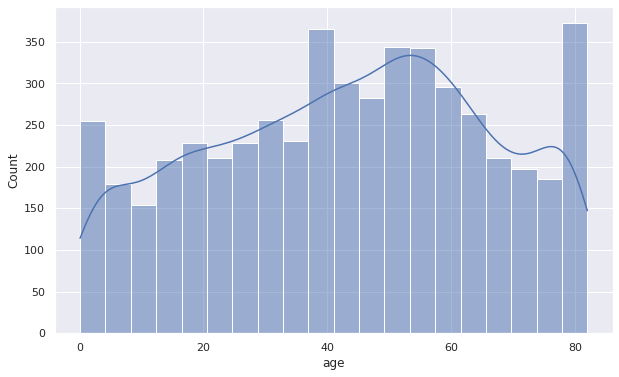

In [7]:
normal_size()
sns.histplot(data=dataset, x='age', kde=True)

In [8]:
dataset['age'].value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
0.48       3
1.40       3
0.16       3
0.08       2
0.40       2
Name: age, Length: 104, dtype: int64

#### Hypertension

Indica si el paciente tiene hipertension o no. Es una variable categorica con los siguentes posibles valores:

In [9]:
dataset['hypertension'].unique()

array([0, 1])

<AxesSubplot:xlabel='Count', ylabel='hypertension'>

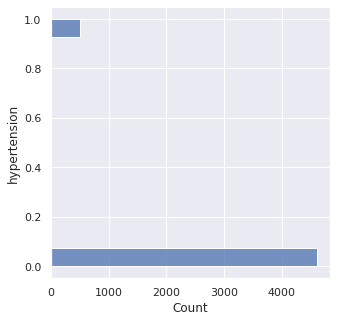

In [10]:
tiny_size()
sns.histplot(data=dataset, y='hypertension')

In [11]:
dataset['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

#### Heart Disease

Explica si el individio tiene una enfermedad cardiaca o no. Es una variable categorica con los siguentes posibles valores:

In [12]:
dataset['heart_disease'].unique()

array([1, 0])

<AxesSubplot:xlabel='Count', ylabel='heart_disease'>

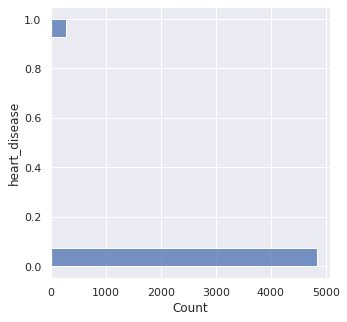

In [13]:
tiny_size()
sns.histplot(data=dataset, y='heart_disease')

In [14]:
dataset['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

#### Ever Married

El individuo estuvo o esta casado?. Es una variable categorica con los siguentes posibles valores:

In [15]:
dataset['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='Count', ylabel='ever_married'>

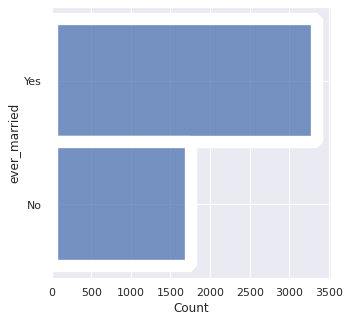

In [16]:
tiny_size()
sns.histplot(data=dataset, y='ever_married')

In [17]:
dataset['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

#### Work Type

Tipo de trabajo. Es una variable categorica con los siguentes posibles valores:

In [18]:
dataset['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

<AxesSubplot:xlabel='Count', ylabel='work_type'>

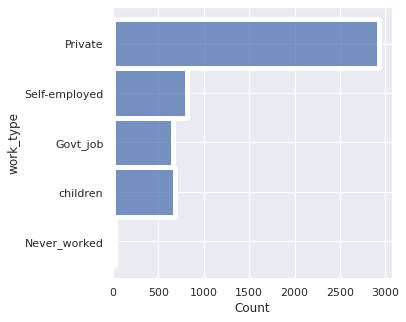

In [19]:
tiny_size()
sns.histplot(data=dataset, y='work_type')

In [20]:
dataset['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

#### Residence type

Tipo de zona donde reside el invididuo. Es una variable categorica con los siguentes posibles valores:

In [21]:
dataset['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

<AxesSubplot:xlabel='Count', ylabel='Residence_type'>

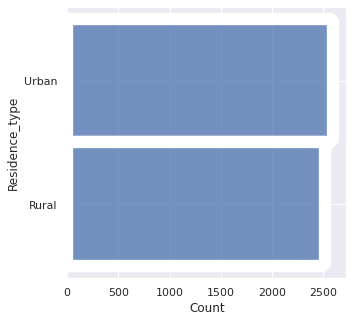

In [22]:
tiny_size()
sns.histplot(data=dataset, y='Residence_type')

In [23]:
dataset['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

#### AVG Glucose Level

Nivel de grucosa medio el individuo. Es una variable numerica.

In [24]:
dataset['avg_glucose_level'].unique()

array([228.69, 202.21, 105.92, ...,  82.99, 166.29,  85.28])

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

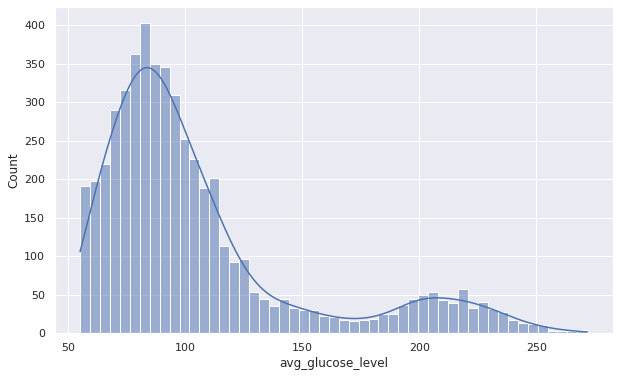

In [25]:
normal_size()
sns.histplot(data=dataset, x='avg_glucose_level', kde=True)

#### BMI

Es una variable numerica. No logro determinar a que se refiere.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

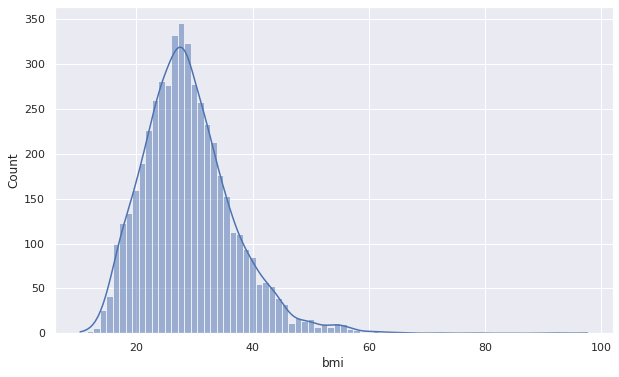

In [26]:
normal_size()
sns.histplot(data=dataset, x='bmi', kde= True)

#### Smoking Status

Se refiere al nivel de fumador al que perteneces el individuo. Es una variable categorica con los siguentes posibles valores:

In [27]:
dataset['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

<AxesSubplot:xlabel='Count', ylabel='smoking_status'>

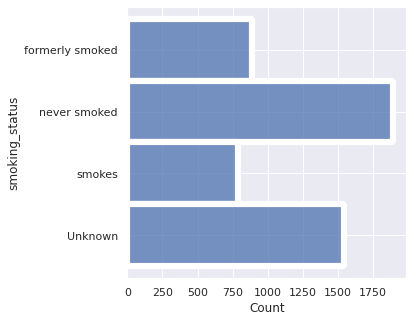

In [28]:
tiny_size()
sns.histplot(data=dataset, y='smoking_status')

In [29]:
dataset['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

#### Stroke

Informa si el individuo sufrio un derrame cerebral o no. Es una variable categorica con los siguentes posibles valores:

In [30]:
dataset['stroke'].unique()

array([1, 0])

<AxesSubplot:xlabel='Count', ylabel='stroke'>

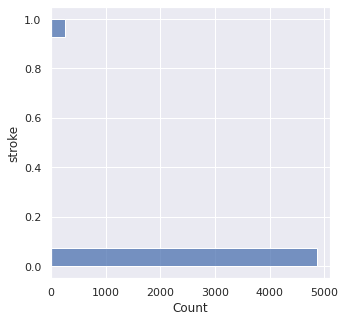

In [31]:
tiny_size()
sns.histplot(data=dataset, y='stroke')

In [32]:
dataset['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

#### b) Reportar si hay valores faltantes. ¿Cuántos son y en qué atributos se encuentran? En caso de haberlos, ¿es necesario y posible asignarles un valor?

Antes de completar valores faltante vamos a separar en dos conjuntos, development y test:

In [165]:
def set_summary(title, features, target):
    print(f'{title}:')
    print('- Features shape:',  features.shape)
    print('- Taget shape:',     target.shape)
    print('- Taget: classes:')
    classes = target.value_counts(normalize=True)
    print(f'\t- Clase {classes.index[0][0]}: {classes[0]*100:0.2f} %')
    print(f'\t- Clase {classes.index[1][0]}: {classes[1]*100:0.2f} %')


def dev_test_summary(dev_features, dev_target, test_features, test_target):
    set_summary('Development Set', dev_features, dev_target)
    set_summary('Test Set',        test_features, test_target)
    
def dev_test_split(dataset, target_col = 'stroke', test_size = 0.3, random_state = 1):
    features = dataset.loc[:, dataset.columns != target_col]
    target   = dataset[[target_col]]
    dev_features, test_features, dev_target, test_target = train_test_split(
        features, 
        target, 
        test_size    = test_size, 
        random_state = random_state,
        stratify     = target.values
    )
    
    dev_test_summary(dev_features, dev_target, test_features, test_target)
    
    return dev_features, test_features, dev_target, test_target

In [166]:
dev_features, test_features, dev_target, test_target = dev_test_split(dataset)

Development Set:
- Features shape: (3577, 11)
- Taget shape: (3577, 1)
- Taget: classes:
	- Clase 0: 95.14 %
	- Clase 1: 4.86 %
Test Set:
- Features shape: (1533, 11)
- Taget shape: (1533, 1)
- Taget: classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %


Ahora veamos que columnas tiene valores faltantes:

In [149]:
def show_missing_values_summary(df):
    result = round(df.isnull().sum() * 100 / len(dataset), 2)
    result = result[result > 0]
    result = result.apply(lambda value: f'{value}%')

    if result.empty:
        print('No missing values!')
    else:
        print('Columns with missing values:')
        print(result)

In [150]:
show_missing_values_summary(dataset)

Columns with missing values:
bmi    3.93%
dtype: object


La unica variable que tiene valores incompletos es BMI y es un 3.93%.

Ahora completamos valores faltantes y comparamos la distribucion de la columna BMI antes y despues de la imputacion:

In [153]:
def impute_missing_values(df, excluded = ['id']):
    num_features = df.select_dtypes(include=np.number)
    num_features = num_features[set(num_features.columns) - set(excluded)]
    
    num_columns     = num_features.columns
    non_num_columns = set(df.columns) - set(num_columns)
    
    # Algoritmo basado en el algoritmo MICE de R
    imputer = IterativeImputer() 
    imputer.fit(num_features)

    imp_num_features = imputer.fit_transform(num_features)

    result_df = pd.DataFrame(
        data    = imp_num_features, 
        columns = num_features.columns
    )
    for col in non_num_columns:
        result_df[col] = df[col].values

    return result_df

def compare_distributions(df1, df2, column):
    sns.kdeplot(df1[column], shade=True, color="r")
    sns.kdeplot(df2[column], shade=True, color="b")

Chequeamos que se hayan completado als columnas y comparamos las distribuciones para development y test:

No missing values!


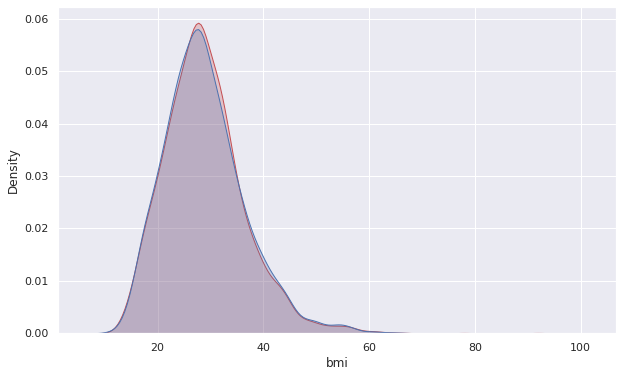

In [154]:
imp_dev_features = impute_missing_values(dev_features)
show_missing_values_summary(imp_dev_features)
compare_distributions(imp_dev_features, dataset, 'bmi')

No missing values!


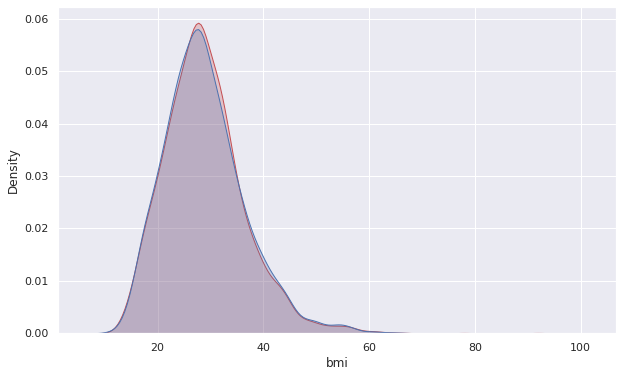

In [157]:
imp_test_features = impute_missing_values(test_features)
show_missing_values_summary(imp_test_features)
compare_distributions(imp_dev_features, dataset, 'bmi')

Ahora la columna BMI esta completa.

#### c) ¿Qué variables se correlacionan más con el evento de lesión (Stroke)? Para las cuatro más correlacionadas, realizar un gráfico en el que se pueda observar la correlación entre la variable y el stroke.

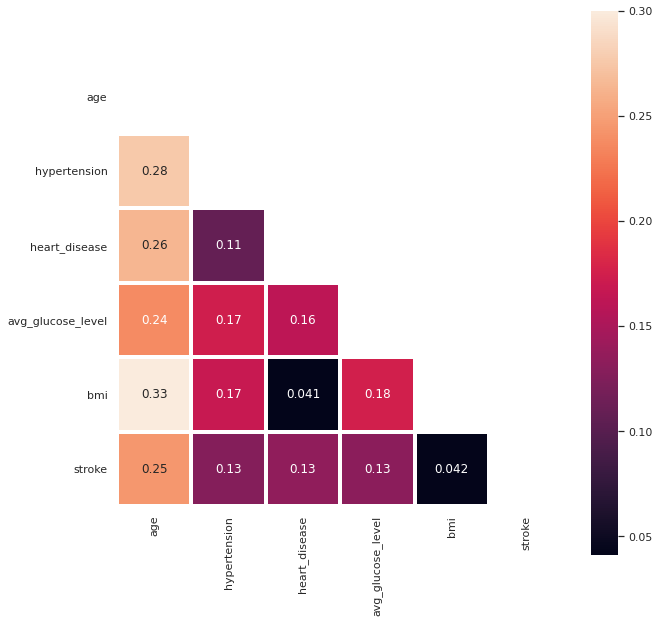

In [158]:
import matplotlib.pyplot as plt

def headmap(corr, resumed=True, figsize=(10, 10), vmax=.3, square=True, annot=True, linewidths=3):
    if resumed:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, vmax=vmax, square=square, annot=annot, linewidths=linewidths)

        
tmp_dataset = dataset.drop('id', axis=1)
headmap(tmp_dataset.corr())

Al parecer stroke tiene baja correlacion con las demas variables pero existe un nivel. El orden de mas correlacionada a menos es:

* Age (0.25)
* Hypertension, Heart Disease y AVG Glucose Level (0.13)
* BMI (0.044)

**Edad vs. dañoi cerebral**

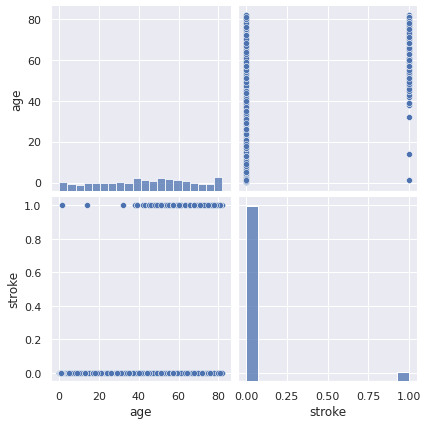

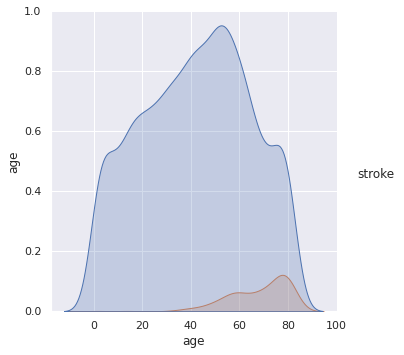

In [159]:
sns.pairplot(tmp_dataset[['age', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['age','stroke']], hue="stroke", height=5)

Conclusiones:

* Ambas densidades estan solapadas.
* Para age <= 23: La probabilidad de tener un daño cereblar es practicamente nula.
* Para age > 23: La probabilidad de tener un daño cereblar es conciderable pero sigue siendo baja con relaciona a la probabilidad de no tener daño cerebral.

**Hipertensión vs daño cerebral**

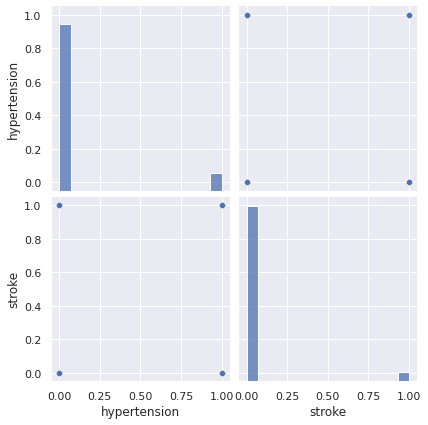

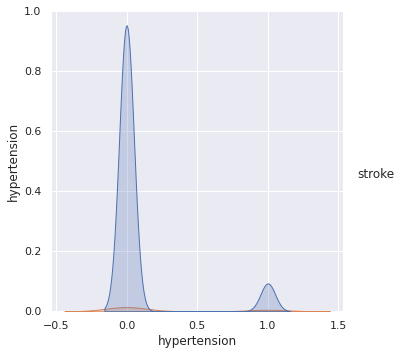

In [160]:
sns.pairplot(tmp_dataset[['hypertension', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['hypertension','stroke']], hue="stroke", height=5)

Conclusiones:
    
* Ambas densidades estan solapadas.
* -0.2 <= hypertension <= 0.2
    * P(Daño cerebral/ Nivel de hipertension) <<<< P(Daño cerebral/ Nivel de hipertension)
* 0.8 <= hypertension <= 1.2
    * P(Daño cerebral/ Nivel de hipertension) <<<< P(No Daño cerebral/ Nivel de hipertension)
* En otros valores hay una probabilidad muy baja de daño cereblar.

**Enfermedad del corazón vs daño cerebral**

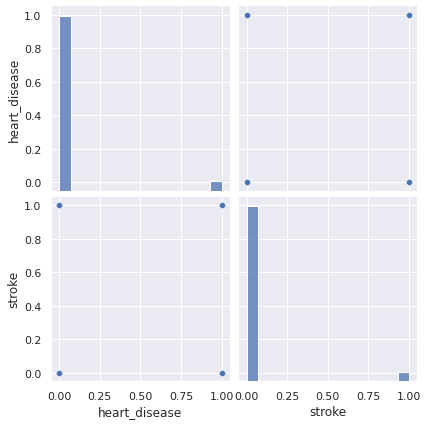

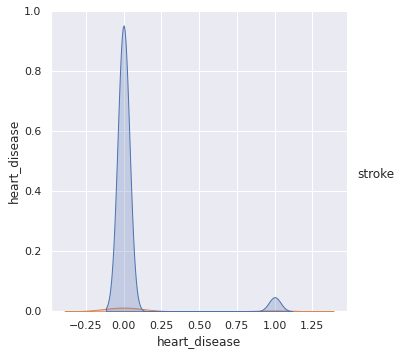

In [161]:
sns.pairplot(tmp_dataset[['heart_disease', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['heart_disease','stroke']], hue="stroke", height=5)

Conclusiones:
    
* Ambas densidades estan solapadas.
* -0.2 <= heart_disease <= 0.2
    * P(Daño cerebral/ Enfermedad del corazón) <<<< P(No Daño cerebral/ Enfermedad del corazón)
* 0.8.5 <= hypertension <= 1.1
    * P(Daño cerebral/ Enfermedad del corazón) <<<< P(No Daño cerebral/ Enfermedad del corazón)
* En otros valores hay una probabilidad muy baja de daño cereblar.

**Promedio del nivel de glucosa vs daño cerebral**

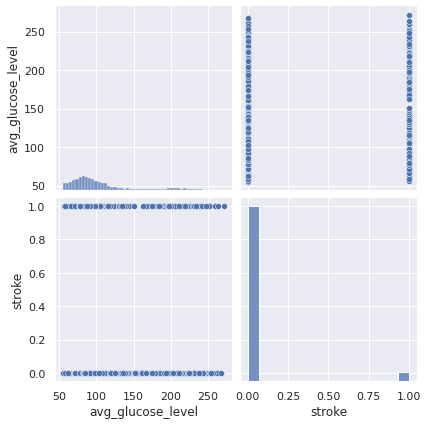

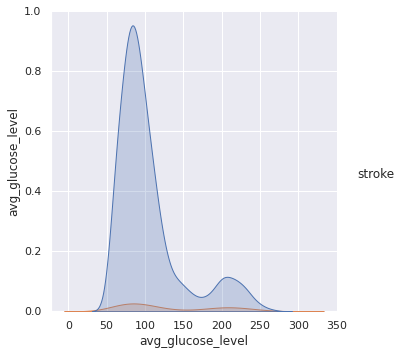

In [162]:
sns.pairplot(tmp_dataset[['avg_glucose_level', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['avg_glucose_level','stroke']], hue="stroke", height=5)

Conclusiones:
    
* Ambas densidades estan solapadas.
* - 40 <= avg_glucose_level <= 170
    * P(Daño cerebral/ nivel de glucosa) <<<< P(No Daño cerebral/ nivel de glucosa)
* 0.8.5 <= hypertension <= 1.1
    * P(Daño cerebral/ nivel de glucosa) <<<< P(No Daño cerebral/ nivel de glucosa)
* En otros valores hay una probabilidad muy baja de daño cereblar.

#### d) Se necesita saber cuáles son los indicadores que determinan más susceptibilidad a sufrir una lesión. ¿Qué atributos utilizará como variables predictoras? ¿Por qué?

Completar

#### e) ¿Se encuentra balanceado el conjunto de datos que utilizará para desarrollar el algoritmo diseñado para contestar el punto d)? En base a lo respondido, ¿qué métricas de performance reportaría y por qué? En caso de estar desbalanceado, ¿qué estrategia de balanceo utilizaría?

In [168]:
dev_test_summary(dev_features, dev_target, test_features, test_target)

Development Set:
- Features shape: (3577, 11)
- Taget shape: (3577, 1)
- Taget: classes:
	- Clase 0: 95.14 %
	- Clase 1: 4.86 %
Test Set:
- Features shape: (1533, 11)
- Taget shape: (1533, 1)
- Taget: classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %


**Claramente esta desbalanceado** dado que es normal tener menos casos de daño cerebral.

#### f) Suponiendo que es más importante detectar los casos en donde el evento ocurre. ¿Qué medida de performance utilizaría? Si utiliza Fβ-Score, ¿qué valor de β eligiría?

**Completar!**

#### g) Implementar el algoritmo introducido en el punto d) utilizando árboles de decisión. En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) es el de desarrollo y es con el que se deberá continuar haciendo el trabajo. Realizar los siguientes puntos

**Completar!**

#### g.1) Armar conjuntos de entrenamiento y validación con proporción 80-20 del conjunto de desarrollo de forma aleatoria. Usar 50 semillas distintas y realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c) en esas 50 particiones distintas.

**Completar!**

#### g.2) Usar validación cruzada de 50 iteraciones (50-fold cross validation). Realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en esas 50 particiones distintas.

**Completar!**

#### h) Graficar el árbol de decisión con mejor performance encontrado en el punto g2). Analizar el árbol de decisión armado (atributos elegidos y decisiones evaluadas).

**Completar!**

#### i) Usando validación cruzada de 10 iteraciones (10-fold cross validation), probar distintos valores de α del algoritmo de poda mínima de complejidad de costos (algoritmo de poda de sklearn). Hacer gráficos de la performance en validación y entrenamiento en función del α. Explicar cómo varía la profundidad de los árboles al realizar la poda con distintos valores de α.

**Completar!**

#### j) Evaluar en el conjunto de evaluación, el árbol correspondiente al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)

**Completar!**

#### k) Para el árbol sin poda, obtener la importancia de los descriptores usando la técnica de eliminación recursiva. Reentrenar el árbol usando sólo los 3 descriptores más importantes. Comparar la performance en el conjunto de prueba.

**Completar!**